<a href="https://colab.research.google.com/github/beaubrown22/KNN/blob/main/Information_based_learning_beau_brown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DSBA 6165: Applied Machine Learning**

Professor: Rick Chakra

TA: Geethika Balasubramanian

# Decision Tree Classifier Building in Scikit-learn

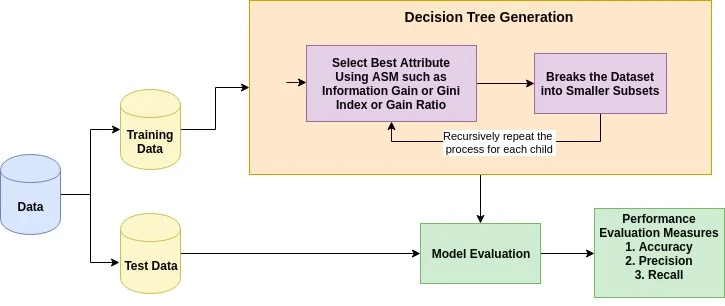

## Importing Required Libraries

Let's first load the required libraries.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets #Import scikit-learn dataset library
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import GridSearchCV # Import for hyperparameter tuning
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix

## Loading Data
Let's first load the required Pima Indian Diabetes dataset using pandas' read CSV function. This time the data is imported through URL instead of last week where it was downloaded on Canvas

In [3]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
# Read csv, using url as file
diabetes = pd.read_csv(url, header=None, names=col_names)
#Look at top rows to insure it worked
diabetes.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Basic EDA and statistical analysis

Let's start of with doing some basic EDA. This should be done every time you are opening a new data set. The only real steps for this is to look at the info to get information on nulls and to look at describe to get statistical information.


In [4]:
# Print dataset info
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  768 non-null    int64  
 1   glucose   768 non-null    int64  
 2   bp        768 non-null    int64  
 3   skin      768 non-null    int64  
 4   insulin   768 non-null    int64  
 5   bmi       768 non-null    float64
 6   pedigree  768 non-null    float64
 7   age       768 non-null    int64  
 8   label     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


The main things to note from this are
1. No Null values
2. All variables are numbers

Now let's move on to the statistics

In [5]:
# Dataset Statistics. We dont need include='all' as all of our variables are numbers!
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnant,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
bp,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
skin,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
pedigree,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
label,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


The question creeping out of this summary is:

*Can minimum value of below listed columns be zero (0)?*

On these columns, a value of zero does not make sense and thus indicates missing value.

Following columns or variables have an invalid zero value:

* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI

It is better to replace zeros with nan since after that counting them would be easier and zeros need to be replaced with suitable values. Since we are going to be heavily messing with the dataset let's make a copy so the original data isn't altered

In [6]:
# Create a deep copy of your dataset
diabetes_copy = diabetes.copy(deep = True)

# Replace the missing values
diabetes_copy[['glucose','bp','skin','insulin','bmi']] = diabetes_copy[['glucose','bp','skin','insulin','bmi']].replace(0,np.NaN)

# Check for missing values
print(diabetes_copy.isnull().sum())

pregnant      0
glucose       5
bp           35
skin        227
insulin     374
bmi          11
pedigree      0
age           0
label         0
dtype: int64


For the sake of time let's fill all of the new null values with the median for the variable.

**DON'T USE EASY FIXES LIKE THIS FOR PROJECT**

In [7]:
# Impute missing values with the median
diabetes_copy.fillna(diabetes_copy.median(), inplace=True)

## Feature Selection
Here, you need to divide given columns into two types of variables dependent (or target variable) and independent variable (or feature variables).

A capital X is used for the dependant variables while a lowercase y is used for the dependant. There is no reason for this other than conventional use in industry

In [8]:
 #split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
# Features
X = diabetes_copy[feature_cols]
# Target variable
y = diabetes_copy.label

## Splitting Data

To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

Let's split the dataset by using function train_test_split(). You need to pass 3 parameters features, target, and test_set size.

In [15]:
# Split dataset into training set and test set, declare random state (seed=1) for repeatability
 # 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [16]:
print('Train target split: ', str(y_train.value_counts()[1] / y_train.value_counts().sum()))
print('Test target split: ', str(y_test.value_counts()[1] / y_test.value_counts().sum()))

Train target split:  0.34823091247672255
Test target split:  0.35064935064935066


## Building Decision Tree Model [link](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Let's create a Decision Tree Model using Scikit-learn. Many of the sklearn algorithms are implemented using the same standard steps:

Step 1: Initiate the algorithm. Define the parameters (& hyperparameters of the algorithm) of the algorithm. For example, the maximum depth, the minimum samples in a leaf etc. (check documentation for more information)

Step 2: Train the algorithm. Train the algorithm by fitting it to the X_train and y_train datasets.

Step 3: Evaluating the algorithm. Evaluate the predictive power of the algorithm by comparing the predicted target values to the true values. We can do this for the training and testing dataset.

In [18]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(random_state=42)

# Train Decision Tree Classifer
dt = dt.fit(X_train, y_train)

# Predict the response for test and train dataset
y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)
# Model Accuracy, how often is the classifier correct?
print("Accuracy Test:",metrics.accuracy_score(y_test, y_pred))
# Check the accuracy for train
print("Accuracy Train:",metrics.accuracy_score(y_train, y_pred_train))

Accuracy Test: 0.7316017316017316
Accuracy Train: 1.0


A training accuracy of 1.0 means that the decision tree has perfectly memorized the training data. Every instance in the training set is correctly predicted by the fully grown tree.
The test accuracy is significantly lower (0.7229), indicating that the model does not generalize well to new, unseen data. The high training accuracy does not translate to good performance on data the model hasn't seen during training.

**Evaluation**

In [19]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
cm=confusion_matrix(y_test,y_pred)
print(cm)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the metrics
print("F1 Score: ", np.round(f1,3))
print("Accuracy: ", np.round(accuracy,3))
print("Precision:", np.round(precision,3))
print("Recall:   ", np.round(recall,3))
tree_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])
print("ROC AUC:", np.round(tree_auc,3))

[[120  30]
 [ 32  49]]
F1 Score:  0.612
Accuracy:  0.732
Precision: 0.62
Recall:    0.605
ROC AUC: 0.702


**Visualizing Decision the fully grown Trees**

You can use Scikit-learn's export_graphviz function for display the tree within a Jupyter notebook.

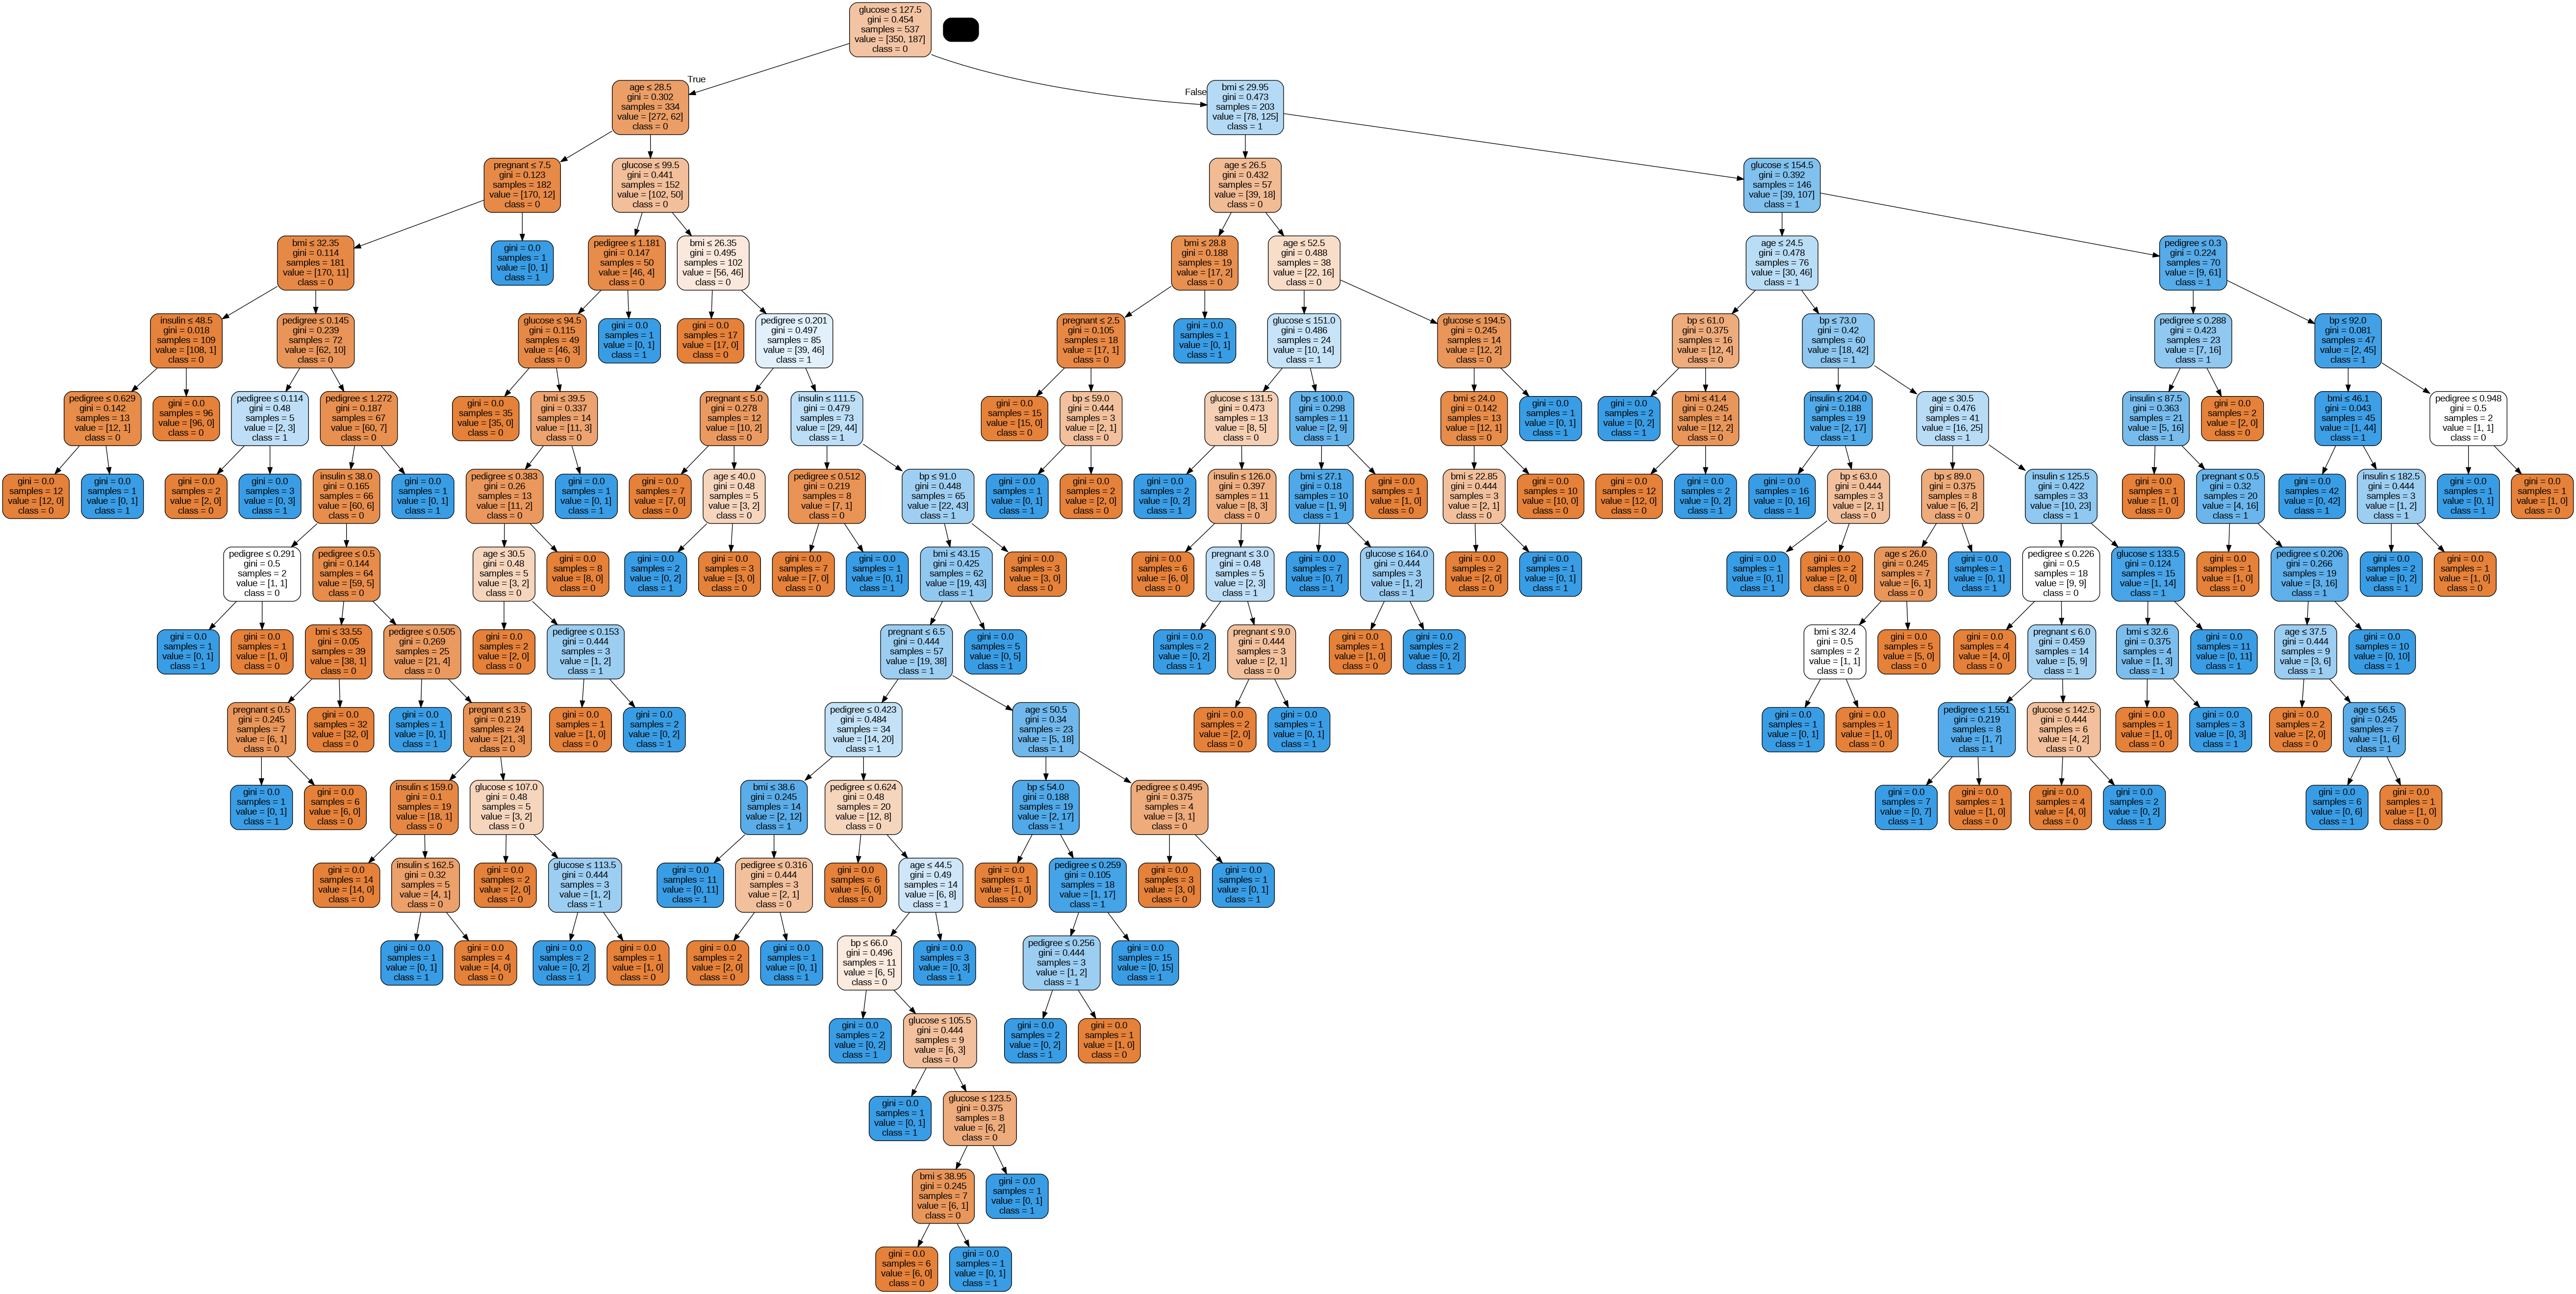

In [24]:
#Import some additional libraries
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

# Plot the decision tree
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('diabetes.png')
Image(graph.create_png())

What's your first reaction when seeing this? Probably something along the lines of "I can't read this!"

This is due to the tree being unpruned. This unpruned tree is unexplainable, overfits, and not easy to understand. In the next section, let's optimize it by pruning.

## How can we enhance the generalization capability and interpretability of a Decision Tree?

**Answer: Tree Pruning**

In Scikit-learn, optimization of decision tree classifier is performed by only pre-pruning. Maximum depth of the tree can be used as a control variable for pre-pruning. In the following the example, you can plot a decision tree on the same data with max_depth=3. Here is a list of other pre-pruning parameters:

**criterion : optional (default=”gini”) or Choose attribute selection measure:** This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.


**max_depth : int or None, optional (default=None) or Maximum Depth of a Tree:** The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting.

In [25]:
# Create Decision Tree classifer object use a different name here. This allows for previous model to be called upon if were to need it.
#Set the hyperparamaneter max_depth=3 and see how the test and train accuracy changes.

dt2 = DecisionTreeClassifier(criterion="entropy", max_depth=3,
                             random_state = 1)

# Train Decision Tree Classifer
dt2 = dt2.fit(X_train,y_train)

y_pred = dt2.predict(X_test)
y_pred_train = dt2.predict(X_train)
# Model Accuracy, how often is the classifier correct?
print("Accuracy Test:",metrics.accuracy_score(y_test, y_pred))
# Check the accuracy for train
print("Accuracy Train:",metrics.accuracy_score(y_train, y_pred_train))

Accuracy Test: 0.7532467532467533
Accuracy Train: 0.7783985102420856


Well, the classification rate increased to 71.8 which is better accuracy than the previous model and it is generalizing better.

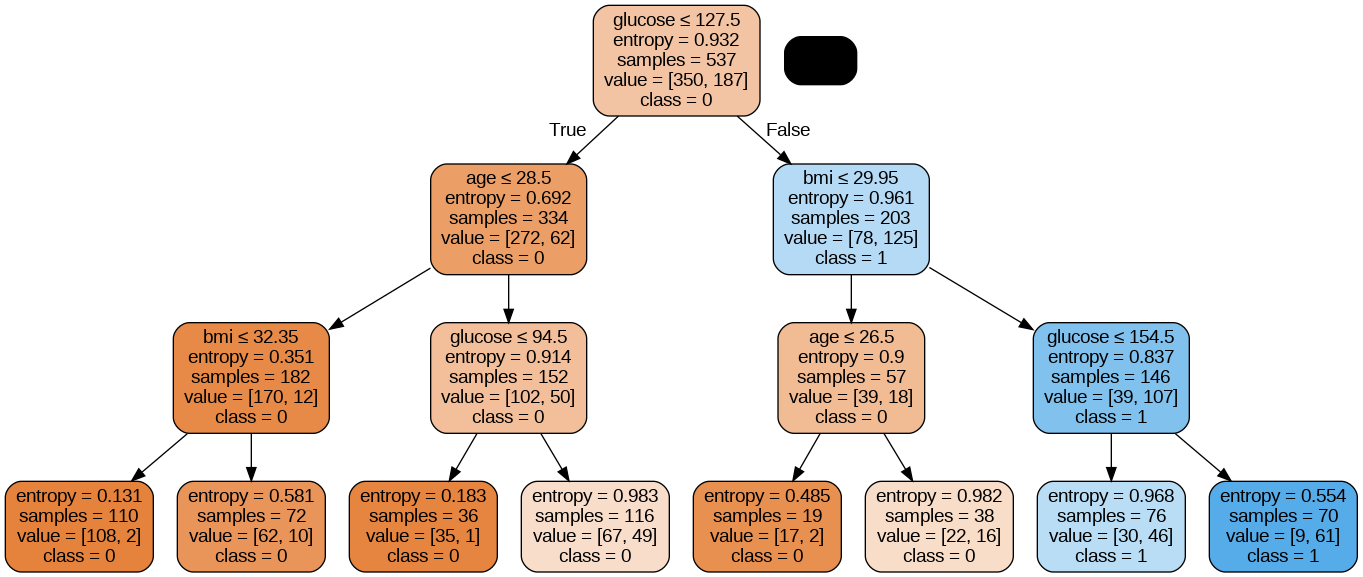

In [26]:
# Plot the decision tree (copy from prior code switching out dt for dt2)
dot_data = StringIO()
export_graphviz(dt2, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('diabetes.png')
Image(graph.create_png())

This pruned model is less complex, explainable, and easy to understand than the previous decision tree model plot. In addition, it should generalize better.

# How to find the best values of hyperparameters? Grid Search

Instead of doing hyperparameter tuning manually, the GridSearchCV function from the sklearn.model_selection library is used to perform an automated grid search for hyperparameter tuning in the Decision Tree model. The param_grid argument defines the hyperparameters to be tuned and the values to be tried. The cv argument sets the number of folds for cross-validation. The fit function is used to fit the model to the data, and the best_params_ and best_score_ attributes are used to get the best hyperparameters and best score, respectively.

The Decision Tree model is defined with the DecisionTreeClassifier class from the sklearn.tree library, and the hyperparameters to be tuned are max_depth, min_samples_split, and min_samples_leaf. The values to be tried for each hyperparameter are specified in the param_grid dictionary. The grid search performs a 10-fold cross-validation, and the best hyperparameters and best score are printed.

In [28]:
# Define the Decision Tree model
model = DecisionTreeClassifier(random_state = 42)

# Define the hyperparameters to be tuned
param_grid = {'criterion': ['entropy','gini'],
              'max_depth': [2, 3, 4],
              'min_samples_split': [2, 3, 4, 5, 6, 7],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7]}

# Perform grid search
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

# Extract best model and evaluate it on test set
best_model = grid.best_estimator_
print("Accuracy of best decision tree: ", best_model.score(X_test, y_test))


Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.7431810314987886
Accuracy of best decision tree:  0.7532467532467533


Automated hyperparameter search identified best params (in agreement with what we found earlier), without manual trial and error.

### Pros
* Decision trees are easy to interpret and visualize.
* It can easily capture Non-linear patterns.
* It requires fewer data preprocessing from the user, for example, there is no need to normalize columns.
* It can be used for feature engineering such as predicting missing values, suitable for variable selection.
* The decision tree has no assumptions about distribution because of the non-parametric nature of the algorithm.

### Cons
* Sensitive to noisy data. It can overfit noisy data.
* The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
* Decision trees are biased with imbalance dataset, so it is recommended that balance out the dataset before creating the decision tree.

## Random Forest Classifier [Link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

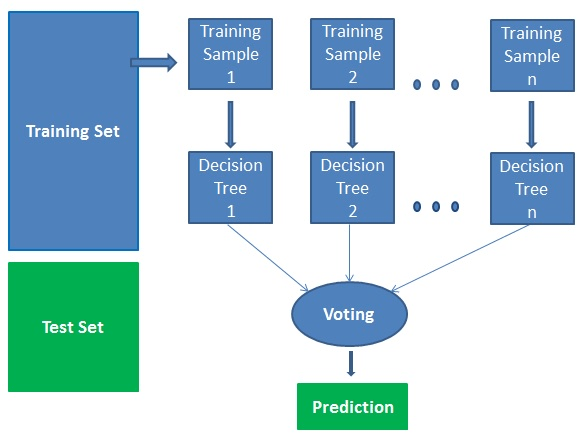

You will be building a model on the diabetes data again! No need to rexplore data as we already did that!

After splitting, you will train the model on the training set and perform predictions on the test set.

In [29]:
#Import Random Forest Function
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf=RandomForestClassifier(n_estimators=10, random_state=1)

#n_estimators: Number of trees in the forest

# Train the model using the training set
rf.fit(X_train,y_train)

# Predict obs in test set
y_pred_rf=rf.predict(X_test)
y_pred_train_rf=rf.predict(X_train)

After training, check the accuracy using actual and predicted values.

In [30]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy Test:",metrics.accuracy_score(y_test, y_pred_rf))
# Check the accuracy for train
print("Accuracy Train:",metrics.accuracy_score(y_train, y_pred_train_rf))

Accuracy Test: 0.7229437229437229
Accuracy Train: 0.994413407821229


Model is clearly overfit. We need to set the hyperparameters.

n_estimator,max_features,max_depth,bootstrap etc.

In [31]:
#Hyperparameter Tuning.
rfc=RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [1, 5, 10, 20, 50, 100, 150, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2,3]
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 4)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 200}

In [34]:
# Create a Random Forest Classifier
rf1=RandomForestClassifier(n_estimators=200, max_depth = 3, max_features='sqrt',random_state=42)
#n_estimators: Number of trees in the forest

# Train the model using the training set
rf1.fit(X_train,y_train)

# Predict obs in test set
y_pred_rf1=rf1.predict(X_test)
y_pred_train_rf1=rf1.predict(X_train)
# Model Accuracy, how often is the classifier correct?
print("Accuracy Test:",metrics.accuracy_score(y_test, y_pred_rf1))
# Model Accuracy, how often is the classifier correct?
print("Accuracy Train:",metrics.accuracy_score(y_train, y_pred_train_rf1))

Accuracy Test: 0.7186147186147186
Accuracy Train: 0.8100558659217877


In [35]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
cm=confusion_matrix(y_test,y_pred_rf1)
print(cm)
f1 = f1_score(y_test, y_pred_rf1)
accuracy = accuracy_score(y_test, y_pred_rf1)
precision = precision_score(y_test, y_pred_rf1)
recall = recall_score(y_test, y_pred_rf1)

# Print the metrics
print("F1 Score: ", np.round(f1,3))
print("Accuracy: ", np.round(accuracy,3))
print("Precision:", np.round(precision,3))
print("Recall:   ", np.round(recall,3))
tree_auc = roc_auc_score(y_test, rf1.predict_proba(X_test)[:,1])
print("ROC AUC:", np.round(tree_auc,3))

[[133  17]
 [ 48  33]]
F1 Score:  0.504
Accuracy:  0.719
Precision: 0.66
Recall:    0.407
ROC AUC: 0.807


For our understanding, Lets try to plot accuracy vs estimators. How does the performance vary with increase in n_estimators

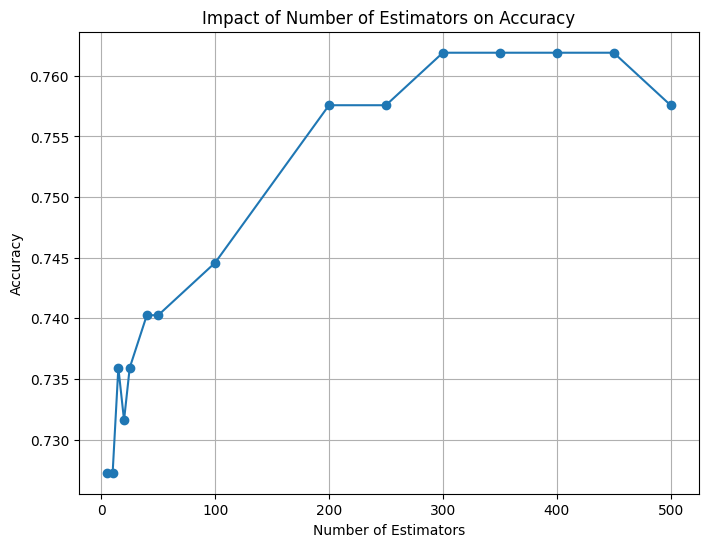

In [36]:
num_estimators_list = [5,10,15,20,25,40, 50, 100, 200,250,300,350,400,450,500]

# Initialize lists to store results
accuracy_results = []

# Iterate over different values of n_estimators
for num_estimators in num_estimators_list:
    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=num_estimators,max_features='sqrt',random_state=42)

    # Fit the classifier to the training data
    rf_classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf_classifier.predict(X_test)

    # Calculate accuracy and store in the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results.append(accuracy)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(num_estimators_list, accuracy_results, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Impact of Number of Estimators on Accuracy')
plt.grid(True)
plt.show()

**Check the individual Trees** in RF

Tree 0


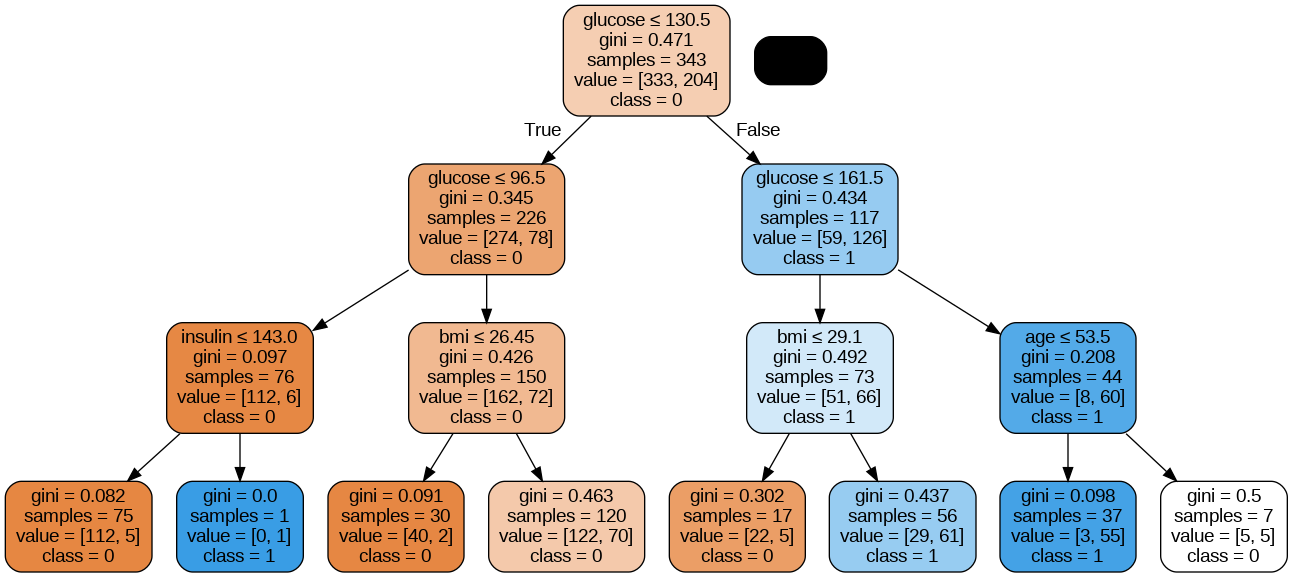

Tree 1


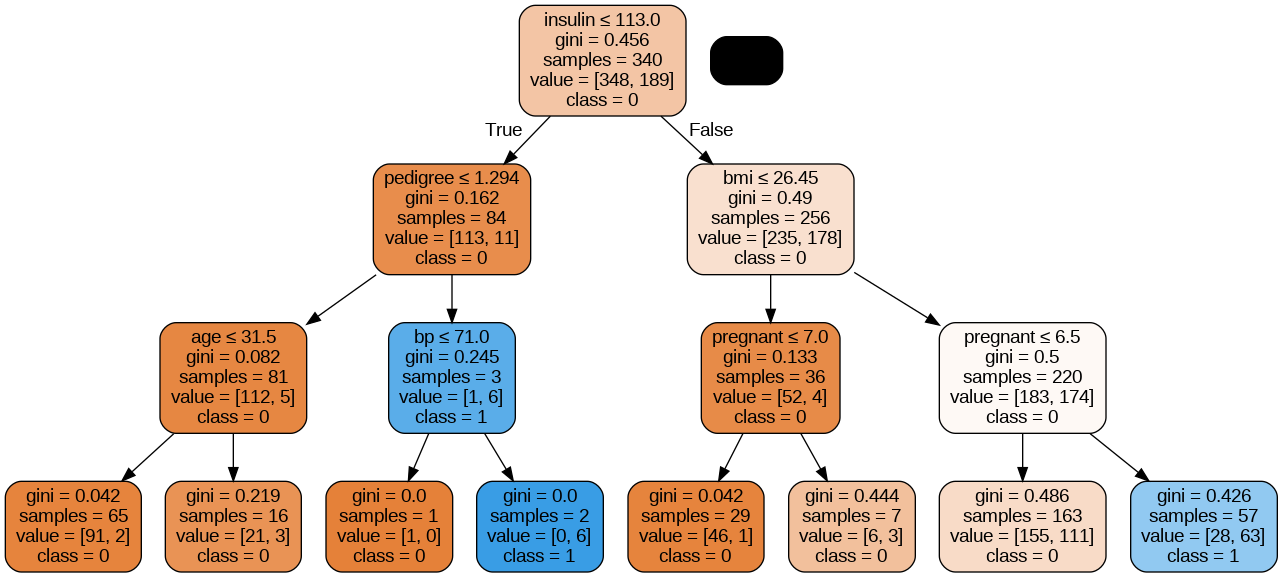

Tree 2


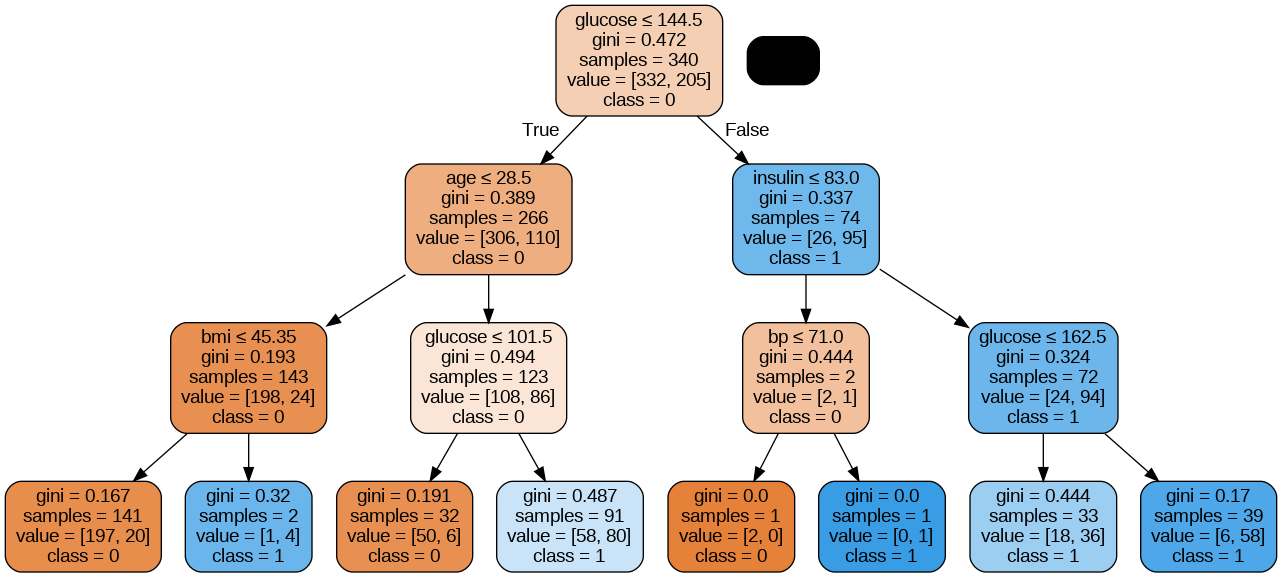

In [38]:
#Plot individual trees in random forest.


num_trees_to_plot = 3

for i in range(num_trees_to_plot):
    # Plot individual trees and save as PNG
    dot_data = StringIO()
    export_graphviz(rf1.estimators_[i]
                    , out_file=dot_data,
                  filled=True, rounded=True,
                   special_characters=True, feature_names = feature_cols,class_names=['0','1'])

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(f'diabetes_tree_{i+1}.png')
    print(f'Tree {i}')
    # Display the plot
    display(Image(graph.create_png()))

Tree 0 Uses Glucose, bmi, pregnant and bp

Tree 1 uses insulin, bp, bmi, pregnant , age

**Random selection of both variables (features) and the creation of individual trees. This randomness is a key aspect of the algorithm and contributes to the overall effectiveness of Random Forests.**



You can also make a prediction for a single item, for example:

* pregnant = 0
* glucose = 115
* bp = 81
* insulin = 133
* bmi = 33
* pedigree = 0.3
* age = 31

Now you can predict which type of flower it is.
Below is the order of the variables from the split earlier in the lab

['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']

In [39]:
print(rf1.predict([[0, 133, 33, 31, 115, 81, 0.3]]))

[0]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Here, 0 indicates not diabetic

## Finding Important Features in Scikit-learn

Here, you are finding important features or selecting features in the diabetes dataset. In scikit-learn, you can perform this task in the following steps:

* First, you need to create a random forests model.
* Second, use the feature importance variable to see feature importance scores.
* Third, visualize these scores using the seaborn library.

**The feature importance in Random Forest is calculated based on how much each feature contributes to reducing impurity or error in the decision trees. Features that are frequently used for splitting nodes across multiple trees and lead to more significant reductions in impurity are considered more important.**

In [40]:
#Look at feature importance
feature_imp = pd.Series(rf1.feature_importances_,index=feature_cols).sort_values(ascending=False)
#Display feature importance
feature_imp

glucose     0.371601
bmi         0.163250
age         0.163107
insulin     0.122988
pregnant    0.074884
pedigree    0.073113
bp          0.031056
dtype: float64

You can also visualize the feature importance. Visualizations are easy to understand and interpretable.

For visualization, you can use a combination of matplotlib and seaborn. Because seaborn is built on top of matplotlib, it offers a number of customized themes and provides additional plot types. Matplotlib is a superset of seaborn and both are equally important for good visualizations.

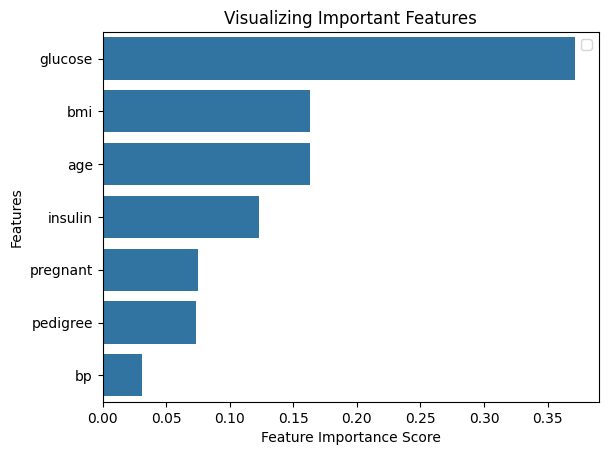

In [41]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


Feature importance helps in selecting the most relevant features for a predictive model. By identifying and focusing on the most important features, you can simplify your model and potentially improve its interpretability.
Feature importance in a Random Forest model provides a means to simplify the model and enhance interpretability.
For instance, variables with importance values below a certain threshold, such as <0.1, can be considered less influential and potentially removed. In scenarios where the model is intricate and involves a large number of variables, feature selection based on importance scores becomes a valuable strategy to reduce complexity and improve model understanding.

# Adaboost classifier

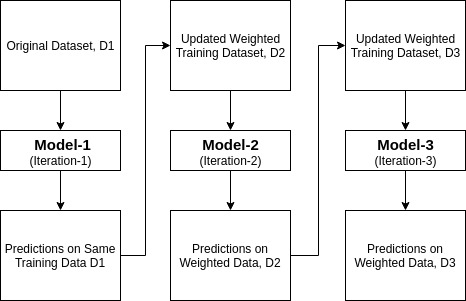

## Importing Required Libraries
Let's first load the required libraries.

In [42]:
# Load library
from sklearn.ensemble import AdaBoostClassifier

## Building the AdaBoost Model

Let's create the AdaBoost Model using Scikit-learn. AdaBoost uses Decision Tree Classifier as default Classifier.

In [46]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=10, algorithm='SAMME',
                         learning_rate=1, random_state=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
y_pred

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

"The most important parameters are base_estimator, n_estimators, and learning_rate." (Adaboost Classifier, Chris Albon)

+ **base_estimator:** It is a weak learner used to train the model. It uses DecisionTreeClassifier as default weak learner for training purpose. You can also specify different machine learning algorithms.
+ **n_estimators:** Number of weak learners to train iteratively.
+ **learning_rate:** It contributes to the weights of weak learners. It uses 1 as a default value.

## Evaluate Model

Let's estimate, how accurately the classifier or model can predict the type of cultivars.

Accuracy can be computed by comparing actual test set values and predicted values.

In [47]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7316017316017316


In [48]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
cm=confusion_matrix(y_test,y_pred)
print(cm)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the metrics
print("F1 Score: ", np.round(f1,3))
print("Accuracy: ", np.round(accuracy,3))
print("Precision:", np.round(precision,3))
print("Recall:   ", np.round(recall,3))
tree_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print("ROC AUC:", np.round(tree_auc,3))

[[120  30]
 [ 32  49]]
F1 Score:  0.612
Accuracy:  0.732
Precision: 0.62
Recall:    0.605
ROC AUC: 0.796


In [49]:
# explore model attributes

print('\nBase Estimator')
display(abc.estimator_)
print('\nEstimators')
display(abc.estimators_)
print('\nEstimator Weights')
display(abc.estimator_weights_)
print('\nEstimator Errors')
display(abc.estimator_errors_)
print('\nFeature Importance')
display(abc.feature_importances_)


Base Estimator


DecisionTreeClassifier(max_depth=1)


Estimators


[DecisionTreeClassifier(max_depth=1, random_state=1791095845),
 DecisionTreeClassifier(max_depth=1, random_state=2135392491),
 DecisionTreeClassifier(max_depth=1, random_state=946286476),
 DecisionTreeClassifier(max_depth=1, random_state=1857819720),
 DecisionTreeClassifier(max_depth=1, random_state=491263),
 DecisionTreeClassifier(max_depth=1, random_state=550290313),
 DecisionTreeClassifier(max_depth=1, random_state=1298508491),
 DecisionTreeClassifier(max_depth=1, random_state=2143362693),
 DecisionTreeClassifier(max_depth=1, random_state=630311759),
 DecisionTreeClassifier(max_depth=1, random_state=1013994432)]


Estimator Weights


array([1.04229386, 0.60491256, 0.63887505, 0.58093853, 0.32982511,
       0.24819965, 0.45695797, 0.22046256, 0.25698212, 0.23634738])


Estimator Errors


array([0.26070764, 0.35322058, 0.34550088, 0.35871667, 0.41828318,
       0.43826668, 0.38770773, 0.44510652, 0.43610571, 0.44118668])


Feature Importance


array([0.        , 0.        , 0.37114802, 0.13105274, 0.39880048,
       0.        , 0.09899876])

In [50]:
# explore prediction outputs

model_predictions = np.zeros(shape=(1,10))

i = 0
for estimator in model.estimators_:
    # print(estimator.predict(X_test.iloc[0:1,:]))
    model_predictions[0][i] = estimator.predict(X_test.iloc[0:1,:])#0 vs 1
    i+=1

print("\nEnsemble Prediction")
print(model.predict(X_test.iloc[0:1,:]))

print("\nEstimator Prediction")
print(model_predictions)

print("\nEstimator Weights")
print(abc.estimator_weights_)



Ensemble Prediction
[1]

Estimator Prediction
[[1. 0. 0. 1. 0. 1. 0. 1. 0. 1.]]

Estimator Weights
[1.04229386 0.60491256 0.63887505 0.58093853 0.32982511 0.24819965
 0.45695797 0.22046256 0.25698212 0.23634738]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without


For further evaluation, you can also create a model using different Base Estimators (can do a gridsearch to find best hyperparameters).

**Pros**

AdaBoost is easy to implement. It iteratively corrects the mistakes of the weak classifier and improves accuracy by combining weak learners. You can use many base classifiers with AdaBoost. AdaBoost is not prone to overfitting. This can be found out via experiment results, but there is no concrete reason available.

**Cons**

AdaBoost is sensitive to noise data. It is highly affected by outliers because it tries to fit each point perfectly. AdaBoost is slower compared to XGBoost.

#XG Boost

XGBoost, or eXtreme Gradient Boosting, is a powerful gradient boosting algorithm known for speed, scalability, and high performance. **The training process in XGBoost involves the sequential construction of decision trees, each aimed at minimizing the overall loss function.**
It incorporates regularization, tree pruning, and feature importance, handles missing values, supports parallel computing, and is widely adopted in competitions. Its versatility makes it a popular choice for regression and classification tasks.

In [51]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

model = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=500,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

XGBoost's hyperparameters read all about them here.  The most common ones that you should know are:

1.learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]

2.max_depth: determines how deeply each tree is allowed to grow during any boosting round.

3.subsample: percentage of samples used per tree. Low value can lead to underfitting.

4.colsample_bytree: percentage of features used per tree. High value can lead to overfitting.

5.n_estimators: number of trees you want to build.
objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability. XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

6.gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.

7.alpha: L1 regularization on leaf weights. A large value leads to more regularization.

8.lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

It's also worth mentioning that though you are using trees as your base learners, you can also use XGBoost's relatively less popular linear base learners and one other tree learner known as dart. All you have to do is set the booster parameter to either gbtree (default), gblinear or dart.



Now, Let's see how the classification error changes with added rounds of boosted tree.

Accuracy: 73.59%


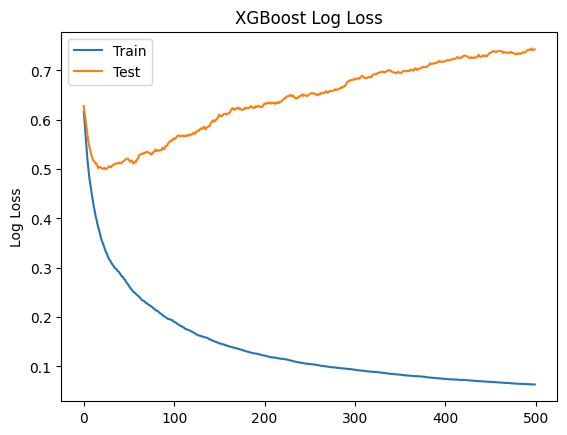

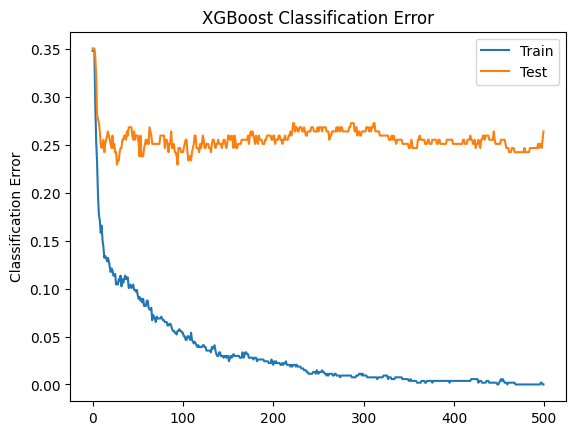

In [52]:
from matplotlib import pyplot
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

The classification error plot distinctly demonstrates a consistent decrease with each boosting iteration for both the training set. However, there is clearly overfitting happening as the number of rounds goes higher.

**Let's Experiment**

**Set an Early stopping rate**

In [54]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

model = xgb.XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=20, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 74.89%


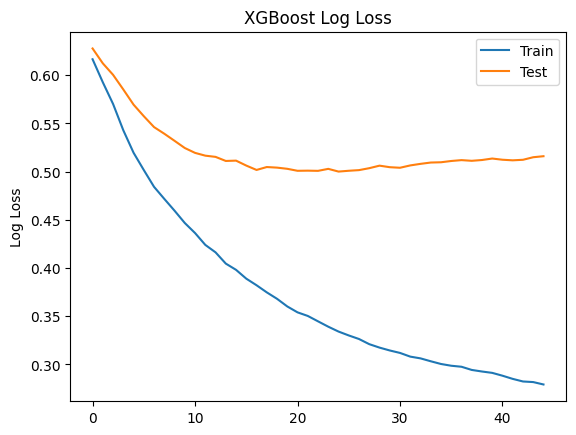

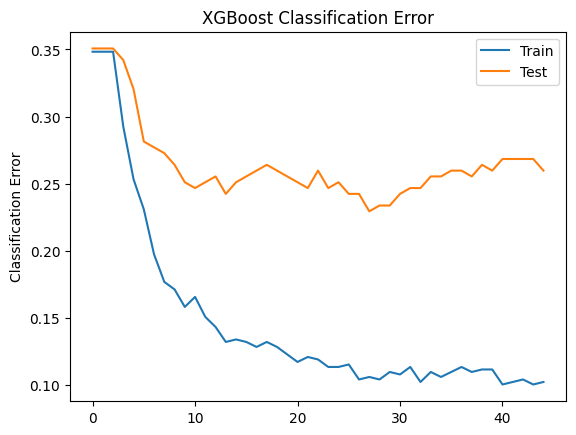

In [55]:
from matplotlib import pyplot
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

    train-error-mean  train-error-std  test-error-mean  test-error-std
45          0.135417         0.003320         0.244792        0.007366
46          0.136719         0.003189         0.242188        0.005524
47          0.136068         0.001841         0.240885        0.004872
48          0.134115         0.002436         0.247396        0.001841
49          0.134766         0.002762         0.243490        0.001841


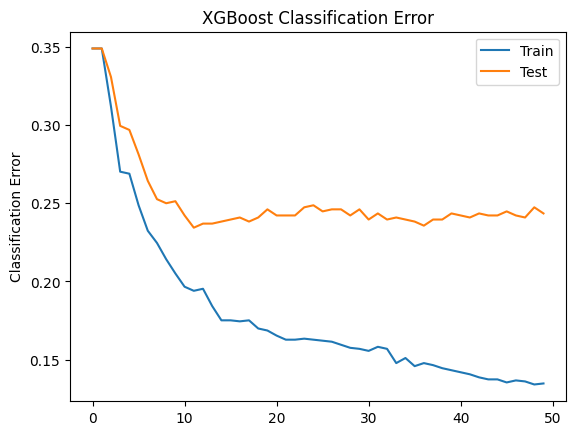

In [56]:
import xgboost as xgb
import numpy as np


#Converting the data to DMatrix
data = xgb.DMatrix(X, label=y)

#Hyperparameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}

#Performing cross-validation
cv_results = xgb.cv(params, data, num_boost_round=50, nfold=3,metrics='error', seed=42)

#Printing the results
print(cv_results.tail())

fig, ax = pyplot.subplots()
ax.plot(cv_results['train-error-mean'],label='Train')
ax.plot(cv_results['test-error-mean'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

**Hyper Parameter  Tuning**

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
params = {'learning_rate': [0.1, 0.25, 0.4],
          'max_depth': [5,10,12],
          'subsample': [0.2,0.3,0.5, 0.7],
          'n_estimators': [5,10,15,20,25,30,35,40,50,150,300]}


random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=5, n_jobs=1, verbose=1,random_state=42)
random_search.fit(X_train, y_train)

print("test_score - " + str(random_search .score(X_test, y_test)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
test_score - 0.7402597402597403


In [58]:
print(random_search.best_params_)

{'subsample': 0.5, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}


In [59]:
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

model = xgb.XGBClassifier(max_depth=5,
                        subsample=0.5,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)
y_pred=model.predict(X_test)
print("train_score - " + str(model .score(X_train, y_train)))
print("test_score - " + str(model .score(X_test, y_test)))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


train_score - 0.8845437616387337
test_score - 0.7359307359307359


**Evaluation**

In [60]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
cm=confusion_matrix(y_test,y_pred)
print(cm)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the metrics
print("F1 Score: ", np.round(f1,3))
print("Accuracy: ", np.round(accuracy,3))
print("Precision:", np.round(precision,3))
print("Recall:   ", np.round(recall,3))
tree_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print("ROC AUC:", np.round(tree_auc,3))


[[127  23]
 [ 38  43]]
F1 Score:  0.585
Accuracy:  0.736
Precision: 0.652
Recall:    0.531
ROC AUC: 0.814


##Over-all Evaluation

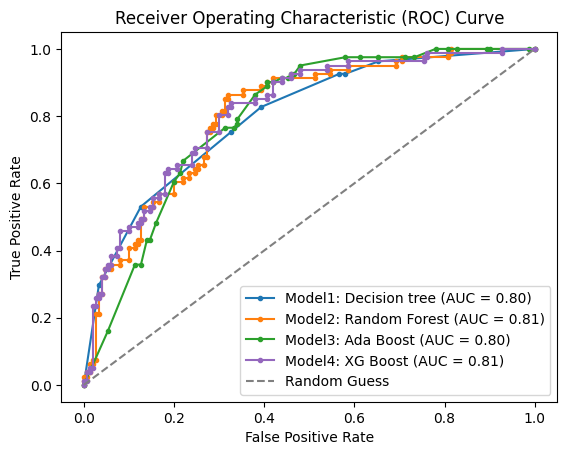

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#  dt2, rf1, abc, and model are your respective models

tree_fpr, tree_tpr, _ = roc_curve(y_test, dt2.predict_proba(X_test)[:, 1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf1.predict_proba(X_test)[:, 1])
gb_fpr, gb_tpr, _ = roc_curve(y_test, abc.predict_proba(X_test)[:, 1])
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

tree_auc = auc(tree_fpr, tree_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
gb_auc = auc(gb_fpr, gb_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.plot(tree_fpr, tree_tpr, marker='.', color='C0', label=f'Model1: Decision tree (AUC = {tree_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, marker='.', color='C1', label=f'Model2: Random Forest (AUC = {rf_auc:.2f})')
plt.plot(gb_fpr, gb_tpr, marker='.', color='C2', label=f'Model3: Ada Boost (AUC = {gb_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, marker='.', color='C4', label=f'Model4: XG Boost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
